In [1]:
import os
import dltools
import torch


In [2]:
with open("./fra-eng/fra.txt",'r',encoding='utf-8') as f:
    raw_text = f.read()
raw_text[:38]


'Go.\tVa !\nHi.\tSalut !\nRun!\tCours\u202f!\nRun!'

In [3]:
def preprocess_nmt(text):
    def no_space(char,prev_char):
        return char in set(',?!.') and prev_char != ' '
    text = text.replace('\u202f',' ').replace('\xa0', ' ').lower()
    out = [' ' + char if  i >0 and no_space(char,text[i-1]) else char  for i,char in enumerate(text)]
    return ''.join(out)
text = preprocess_nmt(raw_text)
print(text[:38])

go .	va !
hi .	salut !
run !	cours !
r


In [4]:
def tokenize_nmt(text,num_example = None):
    soure ,target = [],[]
    for i,line in enumerate(text.split('\n')):
        if num_example and i > num_example:
            break
        parts = line.split('\t')
        if len(parts) ==2:
            soure.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return soure,target

source,target = tokenize_nmt(text)
source[43],target[43]

(['hug', 'me', '.'], ['serrez-moi', 'dans', 'vos', 'bras', '!'])

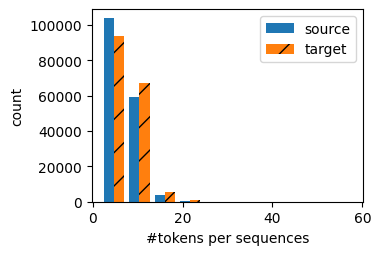

In [5]:
def show_list_len_pair_hist(legend,xlabel,ylabel,xlist,ylist):
    dltools.set_figsize()
    _,_,patches = dltools.plt.hist([[len(l) for l in xlist],[len(l) for l in ylist]])
    dltools.plt.xlabel(xlabel)
    dltools.plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    dltools.plt.legend(legend)
show_list_len_pair_hist(['source','target'],'#tokens per sequences','count',source,target)

In [6]:
src_vocab = dltools.Vocab(source,2,reserved_tokens=['<pad>','<bos>','<eos>'])
len(src_vocab)

10012

In [7]:
def truncate_pad(line,num_steps,padding_token):
    if len(line)>num_steps:
        return line[:num_steps]
    return line + [padding_token] * (num_steps - len(line))
truncate_pad(src_vocab[source[0]],10,src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [8]:
def build_array_nmt(lines,vocab,num_steps):
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(l,num_steps,vocab['pad'])for l in lines] )
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array,valid_len
def load_data_nmt(batch_size, num_steps, num_example=600):
    text = preprocess_nmt(raw_text)
    source, target = tokenize_nmt(text)
    
    src_vocab = dltools.Vocab(source, 2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = dltools.Vocab(target, 2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    
    data_array = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = dltools.load_array(data_array, batch_size)
    
    return data_iter, src_vocab, tgt_vocab

train_iter ,src_vocab,tgt_vocab = load_data_nmt(batch_size=2,num_steps=8)


In [9]:
for X,X_valid_len,y,y_valid_len in train_iter:
    print('X',X.type(torch.int32))
    print('X valid len', X_valid_len)
    print('y',y.type(torch.int32))
    print('y valid len', y_valid_len)
    break

X tensor([[ 12,  55,  15,  18, 182,   4,   3,   0],
        [  6, 124,  37,  45, 222,   4,   3,   0]], dtype=torch.int32)
X valid len tensor([8, 8])
y tensor([[ 16,  11, 138,   8,  31, 139,  40, 180],
        [ 14, 140, 150, 593,   4,   3,   0,   0]], dtype=torch.int32)
y valid len tensor([8, 8])
